# Experiments results 

- Experiment 1: MACHO (PT) - Ogle (FT)
- Experiment 2: MACHO (PT) - Subsets of Ogle (FT) (20 - 50 - 100 observations per class)

In [54]:
cd /tf/astromer

/tf/astromer


In [55]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to disable GPU
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import matplotlib.pyplot as plt
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

def load_weights(model, weights_path):
    model.load_weights(weights_path)
    model.trainable=False
    return model

In [57]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Experiment 1: Pretraning on MACHO - Finetuning on Ogle

In [58]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from presentation.experiments.exp_1_old import get_mlp, get_lstm, get_lstm_att, init_astromer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from core.data import load_records_v3

In [59]:
from core.encoder import Encoder, EncoderLayer
from core.attention import MultiHeadAttention

In [60]:
def load_model(model, path_weights=''):
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
    load_status = model.load_weights(path_weights)
    return model

In [61]:
astromer_weights = './weights/astromer_10022021/finetuning/asas'
exp_folder = './experiments/exp_1/asas/'
data_exp = './data/records/asas/'

In [62]:
test_obj_df = pd.read_csv(data_exp+'test_objs.csv')

classes_name = list(test_obj_df['class'].unique())
print(classes_name)
num_classes = len(classes_name)

['Beta Persei', 'Classical Cepheid', 'RR Lyrae FM', 'Semireg PV', 'W Ursae Ma']


In [63]:
encoder = init_astromer(astromer_weights)

In [64]:
lstm     = get_lstm(256, num_classes, 200, dropout=0.5)
lstm     = load_model(lstm, exp_folder+"/lstm/ckpt")

lstm_att = get_lstm_att(256, num_classes, encoder=encoder, dropout=0.5)
lstm_att = load_model(lstm_att, exp_folder+"/lstm_att/ckpt")

mlp_att  = get_mlp(num_classes, encoder)
mlp_att  = load_model(mlp_att, exp_folder+"/mlp_att/ckpt")

In [65]:
test_batches = load_records_v3(data_exp+'/test', batch_size=256, 
                            max_obs=200,
                            is_train=False,
                            num_cls=num_classes) # repeat 1 == no repeat

Testing mode


In [66]:
%%time
y_pred_lstm = np.argmax(lstm.predict(test_batches), 1)
y_pred_lstm_att = np.argmax(lstm_att.predict(test_batches), 1)
y_pred_mlp_att = np.argmax(mlp_att.predict(test_batches), 1)

CPU times: user 2min 9s, sys: 13.5 s, total: 2min 23s
Wall time: 25.5 s


In [67]:
y_true = np.concatenate([tf.argmax(y, 1) for x, y in test_batches], 0)

In [68]:
%%time
lstm_results     = {'name': 'LSTM', 'y_pred': [], 'y_true': [], 'cce': 0., 'acc':0.}
mlp_att_results  = {'name': 'MLP+ATT', 'y_pred': [], 'y_true': [], 'cce': 0., 'acc':0.}
lstm_att_results = {'name': 'LSTM+ATT', 'y_pred': [], 'y_true': [], 'cce': 0., 'acc':0.}


lstm_results['y_pred'] = y_pred_lstm
lstm_results['y_true'] = y_true
lstm_results['cce'], lstm_results['acc'] = lstm.evaluate(test_batches)

lstm_att_results['y_pred'] = y_pred_lstm_att
lstm_att_results['y_true'] = y_true
lstm_att_results['cce'], lstm_att_results['acc'] = lstm_att.evaluate(test_batches)

mlp_att_results['y_pred'] = y_pred_mlp_att
mlp_att_results['y_true'] = y_true
mlp_att_results['cce'], mlp_att_results['acc'] = mlp_att.evaluate(test_batches)

9/9 [==============================] - 10s 967ms/step - loss: 1.0723 - accuracy: 0.6307
CPU times: user 2min 28s, sys: 17.2 s, total: 2min 45s
Wall time: 29.8 s


In [69]:
# from sklearn.metrics import accuracy_score

print(mlp_att_results['acc'], lstm_att_results['acc'], lstm_results['acc'])

0.630671501159668 0.7127948999404907 0.6715063452720642


In [70]:
# lstm_s = [0.09, 0.10, 0.09, 0.11]
# mlp_s = [0.48, 0.56, 0.55, 0.66]
# lstm_att_s = [0.58, 0.63, 0.62, 0.75]

In [71]:
# plt.figure(figsize=(5,3), dpi=300)
# x_range = [20, 50, 100, 500]
# plt.plot(x_range, lstm_s, marker='o', label='LSTM')
# plt.plot(x_range, mlp_s, marker='o', label='MLP+ATT')
# plt.plot(x_range, lstm_att_s, marker='o', label='LSTM+ATT')
# plt.ylabel('Macro F1 Score')
# plt.xlabel('Samples per class')
# plt.xticks(x_range)
# plt.legend()
# plt.show()

In [72]:
print('{} & {} & {} & {} \\\\\hline'.format('Model', 'F1 Score', 'Recall', 'Precision', 'Accuracy'))
for result in [lstm_results, mlp_att_results, lstm_att_results]:        
    prec, recall, f1, _ = precision_recall_fscore_support(result['y_true'], 
                                                          result['y_pred'], 
                                                          average='macro')
    acc = accuracy_score(result['y_true'], result['y_pred'])
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\\hline'.format(result['name'], f1, recall, prec, acc))
    
    scores = [f1, recall, prec, acc]
#     print(scores)

Model & F1 Score & Recall & Precision \\\hline
LSTM & 0.48 & 0.45 & 0.55 & 0.67 \\\hline
MLP+ATT & 0.37 & 0.36 & 0.39 & 0.63 \\\hline
LSTM+ATT & 0.60 & 0.64 & 0.60 & 0.72 \\\hline


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
import tensorboard as tb

In [21]:
# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
from tensorflow.python.summary.summary_iterator import summary_iterator

def get_metrics(logs_dir):
    acc_values = []
    loss_values = []
    steps_values = []
    walltimes = []
    for path_log in os.listdir(logs_dir):

        if not path_log.endswith('.v2'): continue
        for summary in summary_iterator(os.path.join(logs_dir, path_log)):
            try:
                tag = summary.summary.value[0].tag
                val = summary.summary.value[0].simple_value

                if tag == 'epoch_loss':
                    loss_values.append(val)
                if tag == 'epoch_accuracy':
                    acc_values.append(val)
                    walltimes.append(summary.wall_time)
                    steps_values.append(summary.step)

            except Exception as e:

                continue
    df = pd.DataFrame()
    df['step'] = steps_values
    df['wall_time'] = walltimes
    df['xentropy'] = loss_values
    df['accuracy'] = acc_values
#     df = df.sort_values('wall_time')    
#     df = df.drop_duplicates(subset='step', keep='first')
    return df

In [22]:
# for x in val_metrics['wall_time'].diff():
#     print(x)

Text(-0.1, 0.5, 'Categorical Cross Entropy')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


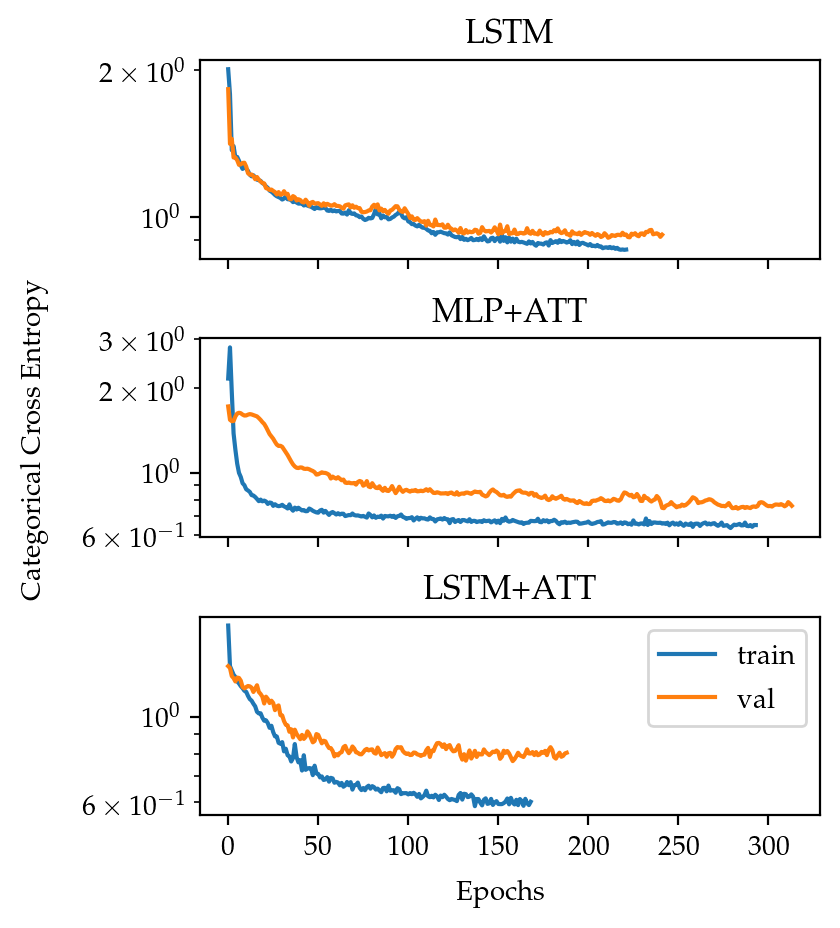

In [23]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=200, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
#     if name != 'lstm':continue
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))

        
    axes[index].plot(train_metrics['xentropy'][:-40], label='train')
    axes[index].plot(val_metrics['xentropy'][:-20], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    
    axes[index].set_yscale('log')

axes[-1].legend()
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(-0.1, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')

Text(0.0, 0.5, 'Accuracy')

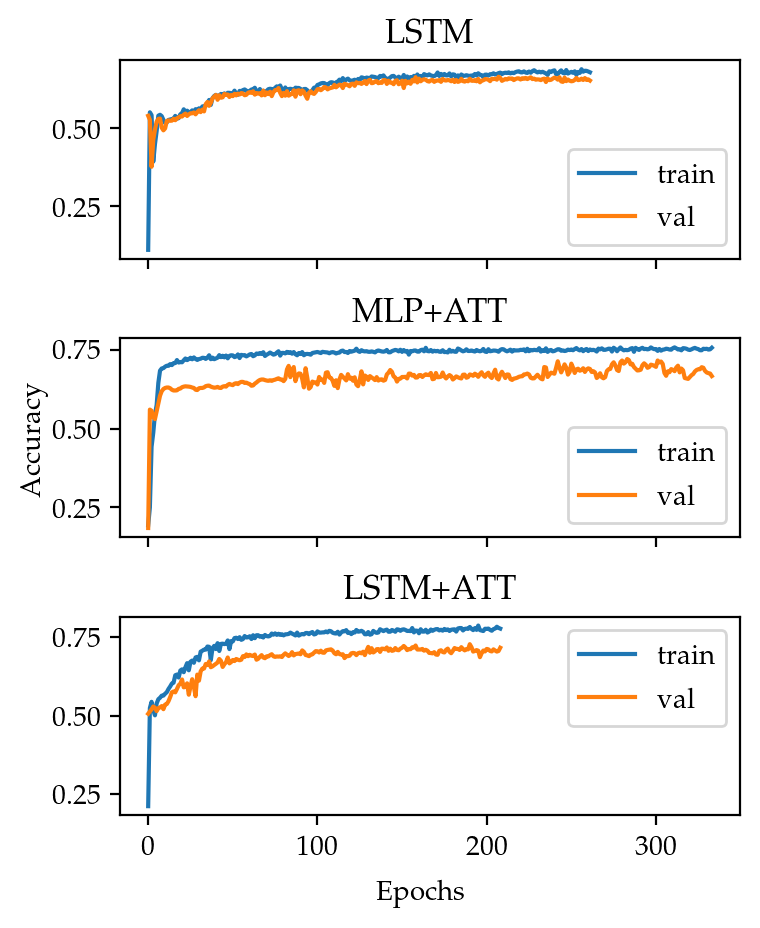

In [24]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=200, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))

        
    axes[index].plot(train_metrics['accuracy'], label='train')
    axes[index].plot(val_metrics['accuracy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Accuracy', va='center', rotation='vertical')

In [25]:
lstm_cm     = confusion_matrix(lstm_results['y_true'], lstm_results['y_pred'], normalize='true')
lstm_att_cm = confusion_matrix(lstm_att_results['y_true'], lstm_att_results['y_pred'], normalize='true')
mlp_att_cm  = confusion_matrix(mlp_att_results['y_true'], mlp_att_results['y_pred'], normalize='true')

In [26]:
classes_name = [x.replace('_', '\_') for x in classes_name]

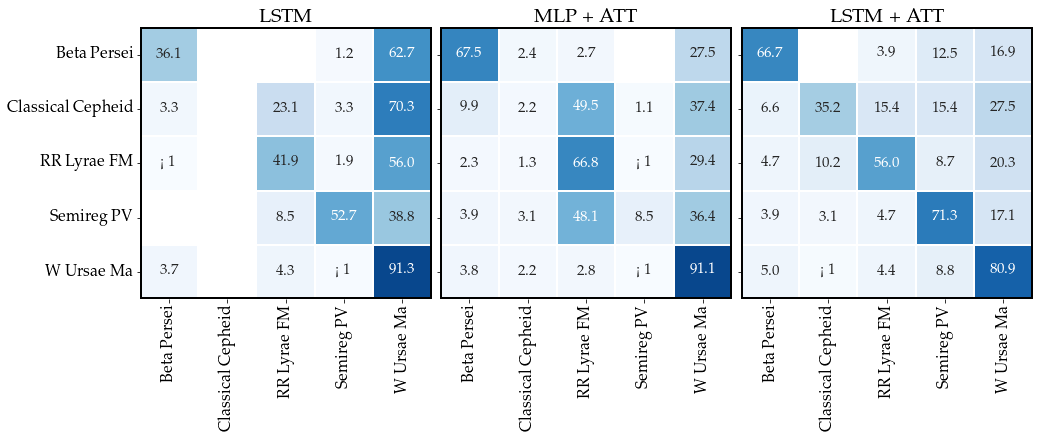

In [27]:
fig, axes = plt.subplots(1,3, figsize=(16,5), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(lstm_cm, axes[0], title='LSTM', class_names=classes_name)
axes[1] = plot_cm(mlp_att_cm, axes[1], title='MLP + ATT', class_names=classes_name)
axes[2] = plot_cm(lstm_att_cm, axes[2], title='LSTM + ATT', class_names=classes_name)